<a href="https://colab.research.google.com/github/chaechocho/CAE/blob/master/convAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import copy
import numpy as np
from sklearn.cluster import KMeans
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

In [ ]:
#Converting data to torch.FloatTensor
transform = transforms.ToTensor()

# Download the training and test datasets
train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

#Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0)

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, stride=2, padding=2, bias=True)
        self.bn1_1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, stride=2, padding=2, bias=True)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=0, bias=True)
        self.embedding = nn.Linear(3*3*128, 3, bias=True)

        self.deembedding = nn.Linear(3, 128*3*3, bias=True)
        self.deconv3 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=0, output_padding=1, bias=True)
        self.bn3_2 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 5, stride=2, padding=2, output_padding=1, bias=True)
        self.bn2_2 = nn.BatchNorm2d(32)
        self.deconv1 = nn.ConvTranspose2d(32, 3, 5, stride=2, padding=2, output_padding=1, bias=True)

        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.relu1_1 = copy.deepcopy(self.relu)
        self.relu2_1 = copy.deepcopy(self.relu)
        self.relu3_1 = copy.deepcopy(self.relu)
        self.relu1_2 = copy.deepcopy(self.relu)
        self.relu2_2 = copy.deepcopy(self.relu)
        self.relu3_2 = copy.deepcopy(self.relu)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1_1(x)
        x = self.bn1_1(x)
        x = self.conv2(x)
        x = self.relu2_1(x)
        x = self.bn2_1(x)
        x = self.conv3(x)
        x = self.relu3_1(x)
        x = x.view(x.size(0), -1)
      
        x = self.embedding(x)
        extra_out = x
        x = self.deembedding(x)

        x = self.relu1_2(x)
        x = x.view(x.size(0), 128, 3, 3)
        x = self.deconv3(x)
        x = self.relu2_2(x)
        x = self.bn3_2(x)
        x = self.deconv2(x)
        x = self.relu3_2(x)
        x = self.bn2_2(x)
        x = self.deconv1(x)
        
        return x, _, extra_out


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CAE()
model = model.to(device)
criterion = nn.MSELoss(size_average=True)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=0.0)
scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
print(model)

CAE(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn1_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (embedding): Linear(in_features=1152, out_features=3, bias=True)
  (deembedding): Linear(in_features=3, out_features=1152, bias=True)
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
  (bn3_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (bn2_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1): ConvTranspose2d(32, 3, kernel_size=(5, 5), stride=(2, 2), pa

In [ ]:
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 10000.0

num_epoch = 100
batch = 256
print_freq = 1563

for epoch in range(num_epoch):
    scheduler.step()
    running_loss = 0.0
    batch_num = 1
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs, _, _ = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

        loss_batch = loss.item()
        loss_accum = running_loss / ((batch_num - 1) * batch + inputs.size(0))

        if batch_num % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                           'Loss {3:.4f} ({4:.4f})\t'.format(epoch + 1, batch_num, len(train_loader),
                                                             loss_batch,
                                                             loss_accum))
        batch_num = batch_num + 1
        
    epoch_loss = loss
    if epoch_loss < best_loss or epoch_loss >= best_loss:
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
model.load_state_dict(best_model_wts)
model.pretrained = True
savePath = "/content/gdrive/My Drive/test_model.pth"
torch.save(model.state_dict(), savePath)

In [ ]:
new_model = CAE()
new_model.load_state_dict(torch.load("/content/gdrive/My Drive/test_model.pth"))

<All keys matched successfully>

In [ ]:
output1 = torch.empty(0, 3)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        _, _, encoded_data = model(images)
        output1 = torch.cat([output1, encoded_data.to("cpu")], dim=0)


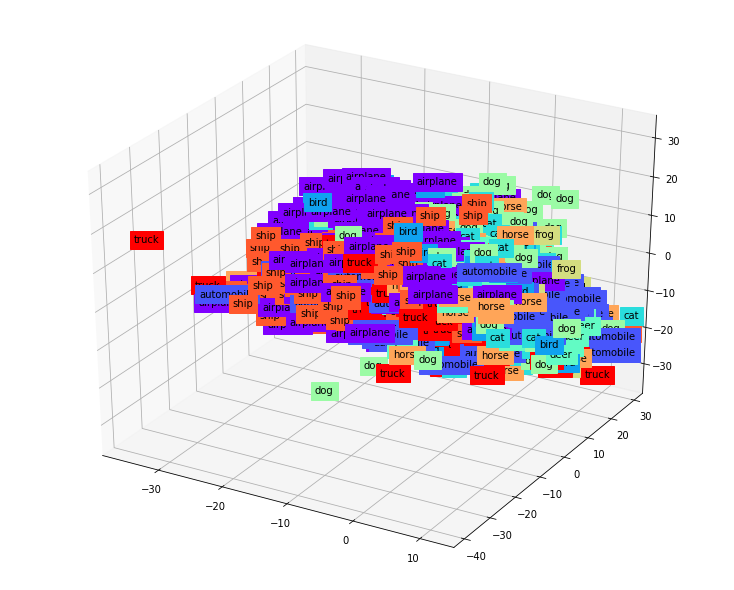

<Figure size 432x288 with 0 Axes>

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt

CLASSES = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)


X = output1.data[:,0].numpy()
Y = output1.data[:,1].numpy()
Z = output1.data[:,2].numpy()

labels = test_data.targets

for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor=color)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()


In [ ]:
plt.savefig("/content/gdrive/My Drive/LatentFeature.png")

<Figure size 432x288 with 0 Axes>

In [ ]:
!pip install kmeans-pytorch

[running kmeans]: 17it [00:00, 92.10it/s, center_shift=3.406874, iteration=18, tol=0.000100]

running k-means on cuda:0..


[running kmeans]: 58it [00:00, 93.85it/s, center_shift=0.000056, iteration=58, tol=0.000100]


SyntaxError: ignored

In [ ]:
# Clustering layer definition (see DCEC article for equations)
class ClusterlingLayer(nn.Module):
    def __init__(self, in_features=10, out_features=10, alpha=1.0):
        super(ClusterlingLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.weight = nn.Parameter(torch.Tensor(self.out_features, self.in_features))
        self.weight = nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        x = x.unsqueeze(1) - self.weight
        x = torch.mul(x, x)
        x = torch.sum(x, dim=2)
        x = 1.0 + (x / self.alpha)
        x = 1.0 / x
        x = x ** ((self.alpha +1.0) / 2.0)
        x = torch.t(x) / torch.sum(x, dim=1)
        x = torch.t(x)
        return x

    def extra_repr(self):
        return 'in_features={}, out_features={}, alpha={}'.format(
            self.in_features, self.out_features, self.alpha
        )

    def set_weight(self, tensor):
        self.weight = nn.Parameter(tensor)


In [ ]:
class CAE_bn3(nn.Module):
    def __init__(self, input_shape=[128,128,3], num_clusters=3, filters=[32, 64, 128], leaky=True, neg_slope=0.01, activations=False, bias=True):
        super(CAE_bn3, self).__init__()
        self.activations=activations
        self.pretrained = False
        self.num_clusters = num_clusters
        self.input_shape = input_shape
        self.filters = filters
        self.conv1 = nn.Conv2d(input_shape[2], filters[0], 5, stride=2, padding=2, bias=bias)
        self.bn1_1 = nn.BatchNorm2d(filters[0])
        if leaky:
            self.relu = nn.LeakyReLU(negative_slope=neg_slope)
        else:
            self.relu = nn.ReLU(inplace=False)
        self.conv2 = nn.Conv2d(filters[0], filters[1], 5, stride=2, padding=2, bias=bias)
        self.bn2_1 = nn.BatchNorm2d(filters[1])
        self.conv3 = nn.Conv2d(filters[1], filters[2], 3, stride=2, padding=0, bias=bias)
        lin_features_len = ((input_shape[0]//2//2-1) // 2) * ((input_shape[0]//2//2-1) // 2) * filters[2]
        #self.embedding = nn.Linear(lin_features_len, num_clusters, bias=bias)

        #self.deembedding = nn.Linear(num_clusters, lin_features_len, bias=bias)
        self.embedding = nn.Linear(128*3*3, num_clusters, bias=bias)

        self.deembedding = nn.Linear(num_clusters, 128*3*3, bias=bias)
              
        
        out_pad = 1 if input_shape[0] // 2 // 2 % 2 == 0 else 0
        self.deconv3 = nn.ConvTranspose2d(filters[2], filters[1], 3, stride=2, padding=0, output_padding=out_pad, bias=bias)
        out_pad = 1 if input_shape[0] // 2 % 2 == 0 else 0
        self.bn3_2 = nn.BatchNorm2d(filters[1])
        self.deconv2 = nn.ConvTranspose2d(filters[1], filters[0], 5, stride=2, padding=2, output_padding=out_pad, bias=bias)
        out_pad = 1 if input_shape[0] % 2 == 0 else 0
        self.bn2_2 = nn.BatchNorm2d(filters[0])
        self.deconv1 = nn.ConvTranspose2d(filters[0], input_shape[2], 5, stride=2, padding=2, output_padding=out_pad, bias=bias)
        self.clustering = ClusterlingLayer(num_clusters, num_clusters)
        # ReLU copies for graph representation in tensorboard
        self.relu1_1 = copy.deepcopy(self.relu)
        self.relu2_1 = copy.deepcopy(self.relu)
        self.relu3_1 = copy.deepcopy(self.relu)
        self.relu1_2 = copy.deepcopy(self.relu)
        self.relu2_2 = copy.deepcopy(self.relu)
        self.relu3_2 = copy.deepcopy(self.relu)
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1_1(x)
        x = self.bn1_1(x)
        x = self.conv2(x)
        x = self.relu2_1(x)
        x = self.bn2_1(x)
        x = self.conv3(x)
        if self.activations:
            x = self.sig(x)
        else:
            x = self.relu3_1(x)
        x = x.view(x.size(0), -1)
      
        x = self.embedding(x)
       
        extra_out = x
        
        clustering_out = self.clustering(x)

        x = self.deembedding(x)
        x = self.relu1_2(x)
#        x = x.view(x.size(0), self.filters[2], ((self.input_shape[0]//2//2-1) // 2), ((self.input_shape[0]//2//2-1) // 2))

        x = x.view(x.size(0), self.filters[2], 3, 3)
        x = self.deconv3(x)
        x = self.relu2_2(x)
        x = self.bn3_2(x)
        x = self.deconv2(x)
        x = self.relu3_2(x)
        x = self.bn2_2(x)
        x = self.deconv1(x)
        if self.activations:
            x = self.tanh(x)
        return x, clustering_out, extra_out


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#model = CAE_3()
model = CAE_bn3()
model = model.to(device)
# Reconstruction loss
criterion_1 = nn.MSELoss(size_average=True)
# Clustering loss
#criterion_2 = nn.KLDivLoss(size_average=False)

#criteria = [criterion_1, criterion_2]

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=0.0)

#optimizer_pretrain = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=0.0)

#optimizers = [optimizer, optimizer_pretrain]

scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)
scheduler_pretrain = lr_scheduler.StepLR(optimizer_pretrain, step_size=200, gamma=0.1)

schedulers = [scheduler, scheduler_pretrain]

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
class CAE_3(nn.Module):
    def __init__(self, input_shape=[128,128,3], num_clusters=3, filters=[32, 64, 128], leaky=True, neg_slope=0.01, activations=False, bias=True):
        super(CAE_3, self).__init__()
        self.activations = activations
        # bias = True
        self.pretrained = False
        self.num_clusters = num_clusters
        self.input_shape = input_shape
        self.filters = filters
        self.conv1 = nn.Conv2d(input_shape[2], filters[0], 5, stride=2, padding=2, bias=bias)
        if leaky:
            self.relu = nn.LeakyReLU(negative_slope=neg_slope)
        else:
            self.relu = nn.ReLU(inplace=False)
        self.conv2 = nn.Conv2d(filters[0], filters[1], 5, stride=2, padding=2, bias=bias)
        self.conv3 = nn.Conv2d(filters[1], filters[2], 3, stride=2, padding=0, bias=bias)
        lin_features_len = ((input_shape[0]//2//2-1) // 2) * ((input_shape[0]//2//2-1) // 2) * filters[2]   #15*15*128
        
        print('lin_features_len', lin_features_len)

        self.embedding = nn.Linear(128*3*3, num_clusters, bias=bias)

        self.deembedding = nn.Linear(num_clusters, 128*3*3, bias=bias)
        
        #self.embedding = nn.Linear(lin_features_len, num_clusters, bias=bias)

        #self.deembedding = nn.Linear(num_clusters, lin_features_len, bias=bias)
        out_pad = 1 if input_shape[0] // 2 // 2 % 2 == 0 else 0
        self.deconv3 = nn.ConvTranspose2d(filters[2], filters[1], 3, stride=2, padding=0, output_padding=out_pad, bias=bias)
        out_pad = 1 if input_shape[0] // 2 % 2 == 0 else 0
        self.deconv2 = nn.ConvTranspose2d(filters[1], filters[0], 5, stride=2, padding=2, output_padding=out_pad, bias=bias)
        out_pad = 1 if input_shape[0] % 2 == 0 else 0
        self.deconv1 = nn.ConvTranspose2d(filters[0], input_shape[2], 5, stride=2, padding=2, output_padding=out_pad, bias=bias)
        self.clustering = ClusterlingLayer(num_clusters, num_clusters)
        # ReLU copies for graph representation in tensorboard
        self.relu1_1 = copy.deepcopy(self.relu)
        self.relu2_1 = copy.deepcopy(self.relu)
        self.relu3_1 = copy.deepcopy(self.relu)
        self.relu1_2 = copy.deepcopy(self.relu)
        self.relu2_2 = copy.deepcopy(self.relu)
        self.relu3_2 = copy.deepcopy(self.relu)
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1_1(x)
        x = self.conv2(x)
        x = self.relu2_1(x)
        x = self.conv3(x)
        if self.activations:
            x = self.sig(x)
        else:
            x = self.relu3_1(x)
        x = x.view(x.size(0), -1)
        x = self.embedding(x)
        extra_out = x
        clustering_out = self.clustering(x)
        x = self.deembedding(x)
        x = self.relu1_2(x)
        #x = x.view(x.size(0), self.filters[2], ((self.input_shape[0]//2//2-1) // 2), ((self.input_shape[0]//2//2-1) // 2))
        x = x.view(x.size(0), self.filters[2], 3, 3)
        
        x = self.deconv3(x)
        x = self.relu2_2(x)
        x = self.deconv2(x)
        x = self.relu3_2(x)
        x = self.deconv1(x)
        if self.activations:
            x = self.tanh(x)
        return x, clustering_out, extra_out

In [ ]:
# 잠재변수를 3D 플롯으로 시각화
print(test_data.data[1].shape)
view_data = torch.from_numpy(test_data.data[:200])
test_x = view_data.to(device)
_, _, encoded_data = model(test_x)
encoded_data = encoded_data.to("cpu")

In [ ]:
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 10000.0

num_epoch = 100
batch = 256
print_freq = 1563

for epoch in range(num_epoch):
    scheduler.step()
    running_loss = 0.0
    batch_num = 1
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs, _, _ = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

        loss_batch = loss.item()
        loss_accum = running_loss / ((batch_num - 1) * batch + inputs.size(0))

        if batch_num % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                           'Loss {3:.4f} ({4:.4f})\t'.format(epoch + 1, batch_num, len(train_loader),
                                                             loss_batch,
                                                             loss_accum))
        batch_num = batch_num + 1
        
    epoch_loss = loss
    if epoch_loss < best_loss or epoch_loss >= best_loss:
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())